In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn import metrics

import scipy.stats as stats
import scipy.signal
from scipy.stats import spearmanr, pearsonr

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

import random
import math
import collections
from collections import Counter
from collections import OrderedDict
from itertools import product
from copy import deepcopy
from tqdm import tqdm, trange

import anndata as ad
import scanpy as sc
import tempfile
import subprocess
import shlex
import logging
# import logomaker
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F

seed = 1337
random.seed(seed)
np.random.seed(seed)

In [2]:
from Bio import SeqIO

def read_fasta_with_biopython(file_path):
    sequences, mfe, length = {}, [], []
    for record in SeqIO.parse(file_path, "fasta"):
        sequence_id = record.id
        sequence = str(record.seq)
        sequences[sequence_id] = sequence
        mfe.append(eval(sequence_id.split('|')[0]))
        length.append(len(sequence))
    return sequences, mfe, length

# 使用示例
file_path = '/scratch/users/yanyichu/UTR-LM/Data/FiveSpecies_EnsemblDatabase/Fivespecies_species_energy_structure_energyNormalDist_214349sequence.fasta'  # 替换为你的 FASTA 文件路径
sequences, mfe, length = read_fasta_with_biopython(file_path)

# 打印第一个序列的标识符和序列内容
first_sequence_id = list(sequences.keys())[0]
first_sequence = sequences[first_sequence_id]
print("Sequence ID:", first_sequence_id)
print("Sequence Content:", first_sequence)


Sequence ID: -27.2|(((.(((.(((.....)))))).)))......((.(((.((..(((..(.(((((.....))))).).))))))))))...(((((((....))))))).|FiveSpecies|human|0.7463667688294459
Sequence Content: CAGTTACACACAGGCAGTGGTATCTGTGAGCAGCTCTGTGGACTCAAAGGTTTTCTCCCTGAGAGGCATGACCCAGGCCAGCTGATTCATCAGAATCAGG


In [3]:
mfe

[-27.2,
 -50.7,
 -106.5,
 -31.6,
 -85.9,
 -60.4,
 -61.3,
 -150.1,
 -34.1,
 -104.3,
 -135.3,
 -185.3,
 -80.8,
 -132.6,
 -50.3,
 -184.9,
 -104.8,
 -254.6,
 -233.2,
 -28.0,
 -80.5,
 -27.3,
 -20.1,
 -42.0,
 -1.1,
 -37.4,
 -14.2,
 -38.6,
 -18.5,
 -115.6,
 -54.8,
 -188.4,
 -46.0,
 -108.3,
 -192.4,
 -34.9,
 -73.7,
 -44.9,
 -65.4,
 -135.0,
 -148.3,
 -37.2,
 -107.5,
 -247.9,
 -58.2,
 -57.7,
 -38.4,
 -48.9,
 -23.6,
 -97.4,
 -207.2,
 -61.4,
 -80.1,
 -193.1,
 -123.9,
 -79.8,
 -38.3,
 -421.8,
 -40.4,
 -18.4,
 -154.4,
 -33.3,
 -85.1,
 -110.0,
 -43.0,
 -46.4,
 -199.1,
 -67.5,
 -23.2,
 -103.9,
 -112.6,
 -186.6,
 -12.3,
 -0.2,
 -103.0,
 -66.2,
 -25.1,
 -137.0,
 -56.5,
 -10.8,
 -300.9,
 -119.9,
 -120.9,
 -46.2,
 -71.4,
 -14.2,
 -39.4,
 -64.3,
 -109.2,
 -22.0,
 -107.7,
 -57.5,
 -76.7,
 -129.3,
 -50.3,
 -28.1,
 -178.0,
 -159.7,
 -236.0,
 -9.2,
 -111.8,
 -30.1,
 -129.6,
 -37.84,
 -7.9,
 -114.8,
 -25.3,
 -57.7,
 -26.7,
 -10.1,
 -66.0,
 -43.2,
 -142.4,
 -172.1,
 -79.2,
 -88.1,
 -62.4,
 -20.6,
 -123.8,
 -30.7

In [4]:
length

[100,
 171,
 301,
 117,
 142,
 192,
 127,
 328,
 100,
 251,
 407,
 451,
 272,
 451,
 184,
 383,
 212,
 1022,
 597,
 73,
 240,
 108,
 92,
 104,
 39,
 114,
 88,
 90,
 68,
 291,
 83,
 479,
 114,
 266,
 501,
 126,
 156,
 112,
 267,
 456,
 328,
 113,
 323,
 625,
 241,
 155,
 165,
 192,
 62,
 257,
 433,
 133,
 172,
 439,
 283,
 201,
 188,
 858,
 153,
 83,
 280,
 134,
 176,
 213,
 129,
 196,
 460,
 185,
 80,
 294,
 333,
 376,
 68,
 34,
 206,
 257,
 96,
 353,
 122,
 56,
 641,
 327,
 369,
 155,
 170,
 48,
 227,
 140,
 280,
 113,
 384,
 130,
 179,
 391,
 163,
 135,
 483,
 294,
 399,
 80,
 299,
 81,
 360,
 124,
 70,
 238,
 135,
 214,
 82,
 43,
 207,
 103,
 571,
 529,
 135,
 255,
 152,
 57,
 269,
 75,
 434,
 161,
 150,
 215,
 338,
 279,
 496,
 69,
 188,
 193,
 171,
 92,
 209,
 50,
 515,
 31,
 128,
 256,
 156,
 1022,
 77,
 37,
 137,
 292,
 130,
 274,
 175,
 119,
 31,
 63,
 244,
 491,
 277,
 132,
 154,
 259,
 636,
 295,
 243,
 90,
 223,
 1022,
 560,
 77,
 183,
 58,
 201,
 441,
 277,
 157,
 118,
 395

In [5]:
def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2


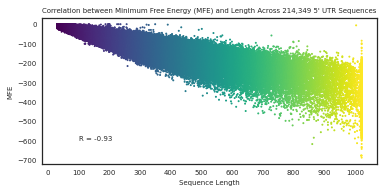

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr, pearsonr

# 创建颜色映射，根据序列长度映射颜色
colors = np.array(length)
plt.figure(figsize = (6,2.7))
# 绘制散点图
plt.scatter(length, mfe, c=colors, cmap='viridis', marker='o', s = 1)

# 设置横纵坐标标签
plt.ylabel('MFE', fontsize=7)
plt.xlabel('Sequence Length', fontsize=7)


plt.tick_params(axis='both', which='both', width=0.5, length=2, labelsize=7)

# 设置坐标轴的字号为7pt
plt.xticks(range(0, 1022, 100), fontsize=7)
plt.yticks(range(-700, 1, 100), fontsize=7)

# 添加标题
plt.title("Correlation between Minimum Free Energy (MFE) and Length Across 214,349 5' UTR Sequences", fontsize=7)

# 计算 Spearman R、Pearson R 和 R2
spearman_corr, _ = spearmanr(mfe, length)
pearson_corr, _ = pearsonr(mfe, length)
r_squared = r2(mfe, length)

# 将计算结果添加到图中
# text = f'R-Squared = {r_squared:.2f}\nSpearman R = {spearman_corr:.2f}\nPearson R = {pearson_corr:.2f}'
text = f'R = {pearson_corr:.2f}'
plt.text(100, -600, text, fontsize=7)
# 显示图形
plt.savefig('/scratch/users/yanyichu/UTR-LM/MJ_FiveSpecies_MFE_length.jpg', dpi = 300)
plt.show()